In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Input, Dense, LayerNormalization, MultiHeadAttention, Dropout, GlobalAveragePooling1D, BatchNormalization
from sklearn.metrics import mean_squared_error
import math
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense

In [119]:
# Cargar el dataset
df = pd.read_csv("../Data/AAPL_2016_2022.csv")

# Drop irrelevant columns
# data = df.drop(columns=['dominant_sentiment', 'average_sentiment'])

# Select features
features = df[['Open',
                 'High', 
                 'Low', 
                 'Close', 
                 'Volume', 
                 'SMA_50', 
                 'SMA_200', 
                 'RSI', 
                 'MACD', 
                 'MACD_signal',
                 #'weighted_sentiment', 'sentiment_momentum', 'tweet_count'
                ]]

# Estandarizar los datos
scaler = StandardScaler()
scaled_data = scaler.fit_transform(features)

# Modificar la función para predecir la columna 'Close'
def create_dataset(dataset, target_column_index, time_step=1):
    """
    Crear ventanas temporales para predicción de una columna objetivo específica.
    
    dataset: numpy.ndarray, datos escalados.
    target_column_index: int, índice de la columna objetivo (Close en este caso).
    time_step: int, tamaño de la ventana temporal.
    """
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        # Seleccionar todas las características para la ventana
        a = dataset[i:(i + time_step), :]  # Todas las columnas para los últimos `time_step` pasos
        dataX.append(a)
        # Agregar el valor objetivo (columna Close) en el paso siguiente
        dataY.append(dataset[i + time_step, target_column_index])
    return np.array(dataX), np.array(dataY)

# Parámetros
time_step = 100
training_size = int(len(scaled_data) * 0.67)
test_size = len(scaled_data) - training_size

# Dividir en entrenamiento y prueba
train_data, test_data = scaled_data[0:training_size, :], scaled_data[training_size:len(scaled_data), :]

# Crear datasets utilizando la columna 'Close' como objetivo (índice 3, ya que Close es la cuarta columna)
target_column_index = 3  # Índice de 'Close' en el conjunto de características
X_train, y_train = create_dataset(train_data, target_column_index, time_step)
X_test, y_test = create_dataset(test_data, target_column_index, time_step)

# Reestructurar los datos para modelos RNN/LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])  # (n_samples, time_steps, n_features)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])      # Igual formato para test

# Comprobación de las dimensiones
print(f"Dimensiones de X_train: {X_train.shape}")
print(f"Dimensiones de y_train: {y_train.shape}")
print(f"Dimensiones de X_test: {X_test.shape}")
print(f"Dimensiones de y_test: {y_test.shape}")


Dimensiones de X_train: (749, 100, 10)
Dimensiones de y_train: (749,)
Dimensiones de X_test: (318, 100, 10)
Dimensiones de y_test: (318,)


In [133]:
# Transformer Block
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    x = LayerNormalization(epsilon=1e-6)(inputs)
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = Dropout(dropout)(x)
    res = x + inputs

    x = LayerNormalization(epsilon=1e-6)(res)
    x = Dense(ff_dim, activation="relu")(x)
    x = Dropout(dropout)(x)
    x = Dense(inputs.shape[-1])(x)
    return x + res

# Model Definition
inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))
x = transformer_encoder(inputs, head_size=256, num_heads=4, ff_dim=4, dropout=0.1)
x = GlobalAveragePooling1D(data_format='channels_first')(x)
x = Dropout(0.1)(x)
x = Dense(20, activation="relu")(x)
outputs = Dense(1, activation="linear")(x)

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer="adam", loss="mean_squared_error")

# Model Summary
model.summary()


Model: "functional_104"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_36      │ (None, 100, 10)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 100, 10)   │         20 │ input_layer_36[0… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 100, 10)   │     44,042 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_154         │ (None, 100, 10)   │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_61 (Add)        │ (None, 100, 10)   │          0 │ dropout_154[0][0… │
│                     │                   │            │ input_layer_36[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 100, 10)   │         20 │ add_61[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_134 (Dense)   │ (None, 100, 4)    │         44 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_155         │ (None, 100, 4)    │          0 │ dense_134[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_135 (Dense)   │ (None, 100, 10)   │         50 │ dropout_155[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_62 (Add)        │ (None, 100, 10)   │          0 │ dense_135[0][0],  │
│                     │                   │            │ add_61[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 100)       │          0 │ add_62[0][0]      │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_156         │ (None, 100)       │          0 │ global_average_p… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_136 (Dense)   │ (None, 20)        │      2,020 │ dropout_156[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_137 (Dense)   │ (None, 1)         │         21 │ dense_136[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 46,217 (180.54 KB)

 Trainable params: 46,217 (180.54 KB)

 Non-trainable params: 0 (0.00 B)

In [134]:
# Callbacks para evitar el overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)

# Entrenar el modelo
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,  # Más épocas para aprovechar EarlyStopping
    batch_size=64,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 227ms/step - loss: 0.5507 - val_loss: 4.0205 - learning_rate: 0.0010
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 163ms/step - loss: 0.1593 - val_loss: 4.6678 - learning_rate: 0.0010
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 159ms/step - loss: 0.1160 - val_loss: 4.3660 - learning_rate: 0.0010
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 171ms/step - loss: 0.0952 - val_loss: 3.9701 - learning_rate: 0.0010
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 170ms/step - loss: 0.0635 - val_loss: 3.9048 - learning_rate: 0.0010
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 167ms/step - loss: 0.0535 - val_loss: 3.8324 - learning_rate: 0.0010
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 161ms/step - loss: 0.0464 - val_loss: 3.7753 - learning_rate: 0.0010
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 163ms/step - loss: 0.0497 - val_loss: 3.6627 - learning_rate: 0.0010
Epoch 9/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 162ms/step - loss: 0.0377 - val_loss: 3.5531 - learning_rate: 0.0010
E

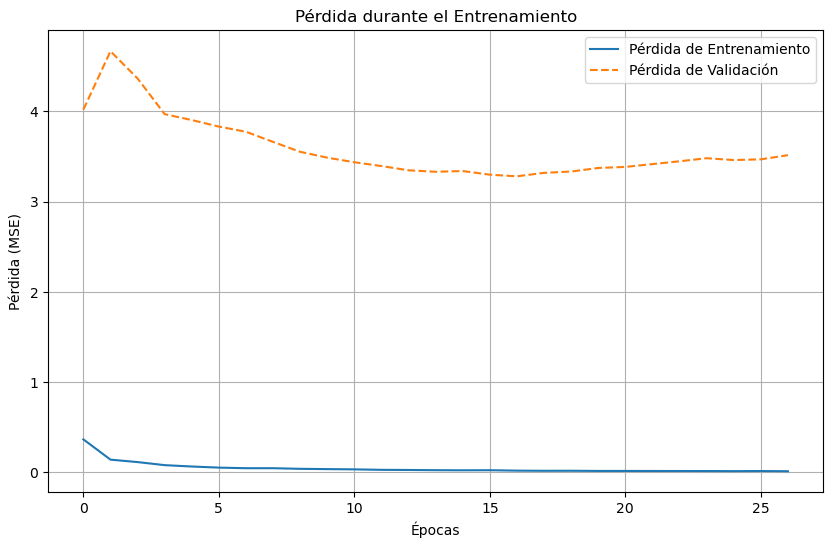

In [135]:
# Graficar las pérdidas de entrenamiento y validación
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Pérdida de Entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de Validación', linestyle='--')
plt.title("Pérdida durante el Entrenamiento")
plt.xlabel("Épocas")
plt.ylabel("Pérdida (MSE)")
plt.legend()
plt.grid()
plt.show()

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.1247
Pérdida en el conjunto de prueba: 0.1029
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step


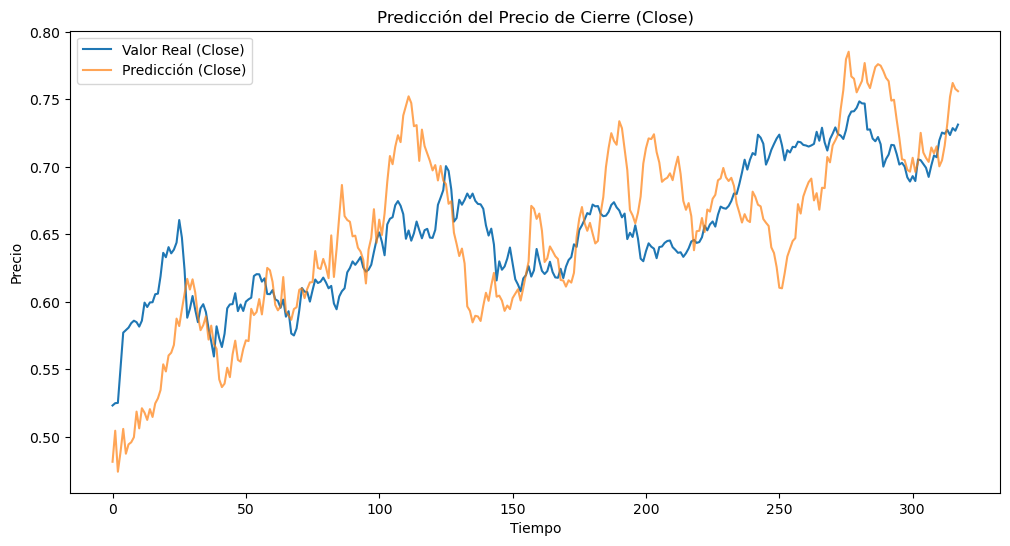

In [123]:
# Evaluar el modelo en el conjunto de prueba
test_loss = model.evaluate(X_test, y_test, verbose=1)
print(f"Pérdida en el conjunto de prueba: {test_loss:.4f}")

# Realizar predicciones
y_pred = model.predict(X_test)

# Desescalado de las predicciones (opcional, si deseas devolver los valores a la escala original)
y_test_original = scaler.inverse_transform(
    np.concatenate((np.zeros((y_test.shape[0], X_test.shape[2]-1)), y_test.reshape(-1, 1)), axis=1)
)[:, -1]

y_pred_original = scaler.inverse_transform(
    np.concatenate((np.zeros((y_pred.shape[0], X_test.shape[2]-1)), y_pred), axis=1)
)[:, -1]

# Visualización de los resultados
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_test_original, label="Valor Real (Close)")
plt.plot(y_pred_original, label="Predicción (Close)", alpha=0.7)
plt.title("Predicción del Precio de Cierre (Close)")
plt.xlabel("Tiempo")
plt.ylabel("Precio")
plt.legend()
plt.show()
